# Main 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folde
import pandas as pd

In [2]:
sys.path.append('../AppStat/AppStat2021/External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

sys.path.append('../AppStat/AppStat2021/Emilie_External_Functions')
from EmilieExternalFunctions import zerobin_hist, chi2_test, get_chi2_values

sys.path.append('BachelorExternalFunctions')
from Bachelor_ExternalFunctions import peak_plotter, peak_finder, compare_peaks
from Bachelor_ExternalFunctions import amp_plotter, amplitudes, get_min_idx

In [101]:
# Set som plotting standards:

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)


save_plots = False

In [4]:
# Getting the data and converting to numpy array: 

dataframe_m = pd.read_csv('Data/mdata.csv', header=None, index_col=None)
dataframe_p = pd.read_csv('Data/pdata.csv', header=None, index_col=None)

dataframe_m = dataframe_m.to_numpy()
dataframe_p = dataframe_p.to_numpy()

In [5]:
# Identifying and saving the traces, where the concentration gets very small. 

removed_traces_m = []
removed_idx = [] 
removed_traces_p = []

for i in range(0, 422): 
    for j in range(49, 287):  # Ocsillation should begin after the 49th datapoint. 
        if dataframe_m[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            
        if dataframe_p[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            break

In [6]:
# Cleaning the dataframes for traces:  

data_m = np.delete(dataframe_m, removed_idx, 0)
data_p = np.delete(dataframe_p, removed_idx, 0)

In [86]:
# Finding the gradient for the first 49 datapoints in each trace: 

grad_p = []
grad_m = []

for i in range(len(data_p)): 
    grad_p.extend(np.gradient(data_p[i][:49]))
    grad_m.extend(np.gradient(data_m[i][:49])) 

In [87]:
# Applying Chauvenet's criterium to remove outliers: 

clean_grad_p = grad_p.copy()
clean_grad_m = grad_m.copy()

for i in range(10): 
    mean_p = np.mean(grad_p)
    std_p = np.std(grad_p)
    
    mean_m = np.mean(grad_m)
    std_m = np.std(grad_m)
    
    dist_p = [2 * stats.norm.sf(abs(clean_grad_p[i] - mean_p) / std_p)*len(clean_grad_p) for i in range(len(clean_grad_p))]
    dist_m = [2 * stats.norm.sf(abs(clean_grad_m[i] - mean_m) / std_m)*len(clean_grad_m) for i in range(len(clean_grad_m))]
    
    remove_p = []
    
    for i in range(len(dist_p)): 
        if dist_p[i] < 0.5: 
            remove_p.append(i)
            
    remove_m = []
            
    for i in range(len(dist_m)): 
        if dist_m[i] < 0.5: 
            remove_m.append(i)
            
    clean_grad_p = np.delete(clean_grad_p, remove_p)
    clean_grad_m = np.delete(clean_grad_m, remove_m)

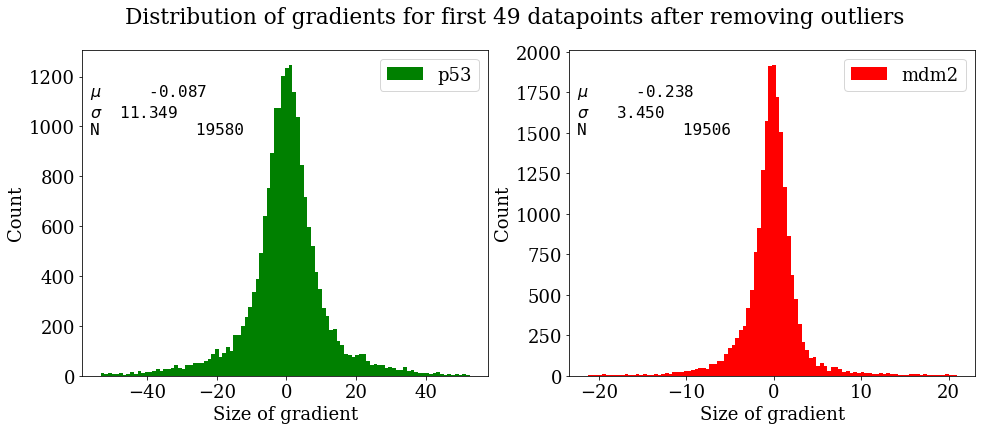

In [99]:
# Plotting the distribution of cleaned gradients

grad_p_min, grad_p_max = min(clean_grad_p), max(clean_grad_p)
grad_m_min, grad_m_max = min(clean_grad_m), max(clean_grad_m)
Nbins = 100

clean_mean_p = np.mean(clean_grad_p)
clean_std_p = np.std(clean_grad_p)
clean_datapoints_p = len(clean_grad_p)

clean_mean_m = np.mean(clean_grad_m)
clean_std_m = np.std(clean_grad_m)
clean_datapoints_m = len(clean_grad_m)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

suptitle = fig.suptitle('Distribution of gradients for first 49 datapoints after removing outliers')

ax[0].hist(clean_grad_p, bins=Nbins, range=(grad_p_min, grad_p_max), color='green', label='p53')
ax[1].hist(clean_grad_m, bins=Nbins, range=(grad_m_min, grad_m_max), color='red', label='mdm2')

ax[0].set(xlabel='Size of gradient', 
          ylabel='Count')
ax[1].set(xlabel='Size of gradient', 
          ylabel='Count')

ax[0].legend()
ax[1].legend()


s_p = {'$\mu$':   clean_mean_p,
       '$\sigma$':   clean_std_p, 
       'N':    clean_datapoints_p}

text_p = nice_string_output(s_p, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.9, text_p, ax[0], fontsize=16, color='black')

s_m = {'$\mu$':   clean_mean_m,
       '$\sigma$':   clean_std_m, 
       'N':    clean_datapoints_m}

text_m = nice_string_output(s_m, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.9, text_m, ax[1], fontsize=16, color='black')

if save_plots: 
    plt.savefig(r'Graphs/DistGradFirst49.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

In [89]:
# Finding the std for the first 49 datapoints in each trace: 

all_std_p = []
all_std_m = []

for i in range(len(data_p)): 
    all_std_p.extend([data_p[i][j] - np.mean(data_p[i][:49]) for j in range(len(data_p[i][:49]))])
    all_std_m.extend([data_m[i][j] - np.mean(data_m[i][:49]) for j in range(len(data_m[i][:49]))])

In [90]:
# Applying Chauvenet's criterium to remove outliers: 

clean_all_std_p = all_std_p.copy()
clean_all_std_m = all_std_m.copy()

for i in range(20): 
    mean_p = np.mean(all_std_p)
    std_p = np.std(all_std_p)
    
    mean_m = np.mean(all_std_m)
    std_m = np.std(all_std_m)
    
    dist_p = [2 * stats.norm.sf(abs(clean_all_std_p[i] - mean_p) / std_p)*len(clean_all_std_p) 
              for i in range(len(clean_all_std_p))]
    dist_m = [2 * stats.norm.sf(abs(clean_all_std_m[i] - mean_m) / std_m)*len(clean_all_std_m) 
              for i in range(len(clean_all_std_m))]
    
    remove_p = []
    
    for i in range(len(dist_p)): 
        if dist_p[i] < 0.5: 
            remove_p.append(i)
            
    remove_m = []
            
    for i in range(len(dist_m)): 
        if dist_m[i] < 0.5: 
            remove_m.append(i)
            
    clean_all_std_p = np.delete(clean_all_std_p, remove_p)
    clean_all_std_m = np.delete(clean_all_std_m, remove_m)

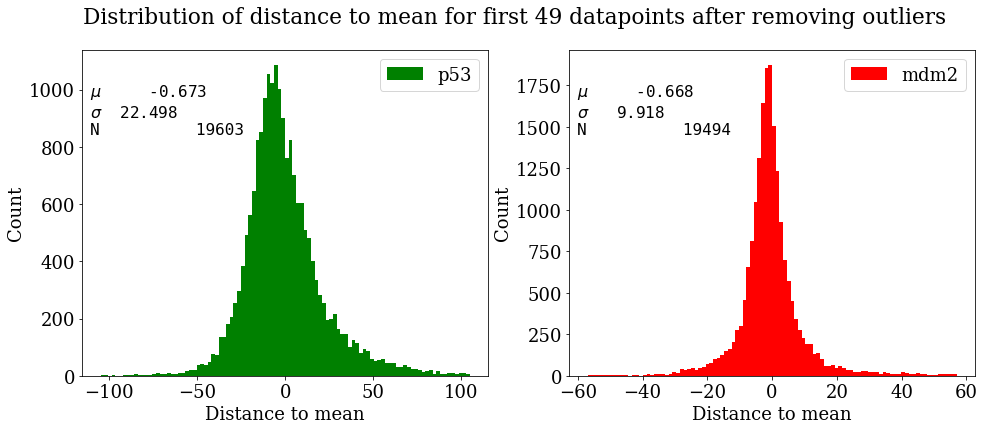

In [100]:
# Plotting the distribution of cleaned gradients

all_std_p_min, all_std_p_max = min(clean_all_std_p), max(clean_all_std_p)
all_std_m_min, all_std_m_max = min(clean_all_std_m), max(clean_all_std_m)
Nbins = 100

clean_std_mean_p = np.mean(clean_all_std_p)
clean_std_std_p = np.std(clean_all_std_p)
clean_std_datapoints_p = len(clean_all_std_p)

clean_std_mean_m = np.mean(clean_all_std_m)
clean_std_std_m = np.std(clean_all_std_m)
clean_std_datapoints_m = len(clean_all_std_m)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

suptitle = fig.suptitle('Distribution of distance to mean for first 49 datapoints after removing outliers')

ax[0].hist(clean_all_std_p, bins=Nbins, range=(all_std_p_min, all_std_p_max), color='green', label='p53')
ax[1].hist(clean_all_std_m, bins=Nbins, range=(all_std_m_min, all_std_m_max), color='red', label='mdm2')

ax[0].set(xlabel='Distance to mean', 
          ylabel='Count')
ax[1].set(xlabel='Distance to mean', 
          ylabel='Count')

ax[0].legend()
ax[1].legend()


s_p1 = {'$\mu$':   clean_std_mean_p,
       '$\sigma$':   clean_std_std_p, 
       'N':    clean_std_datapoints_p}

text_p1 = nice_string_output(s_p1, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.9, text_p1, ax[0], fontsize=16, color='black')

s_m1 = {'$\mu$':   clean_std_mean_m,
       '$\sigma$':   clean_std_std_m, 
       'N':    clean_std_datapoints_m}

text_m1 = nice_string_output(s_m1, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.9, text_m1, ax[1], fontsize=16, color='black')

if save_plots: 
    plt.savefig(r'Graphs/DistDistanceFirst49.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

In [112]:
# Using the std of the gradient distribution as initial fitting errors

avefluct_m = clean_std_m 
avefluct_p = clean_std_p

print(f'The mean fluctuations before oscillations: {avefluct_m:.4f}(mdm2) and {avefluct_p:.4f}(p53)')

The mean fluctuations before oscillations: 3.4505(mdm2) and 11.3488(p53)


In [105]:
# Removing noise by fitting a fourth order polynomium: 

time = np.linspace(0, 287/2, 287)
t = time[49:]

resi_m = []
resi_p = []

for i in range(len(data_p)):
    coef_p = np.polyfit(t, data_p[i][49:], 4)
    coef_m = np.polyfit(t, data_m[i][49:], 4)
    
    resi_p.append(data_p[i][49:] - np.polyval(coef_p[:], t))
    resi_m.append(data_m[i][49:] - np.polyval(coef_m[:], t))

print(f'The mean of the p53 and Mdm2 residuals: {np.mean(resi_p):.5f} and {np.mean(resi_m):.6f}')

The mean of the p53 and Mdm2 residuals: -0.00000 and -0.000000


In [106]:
# Shifting all mdm2 traces three places: 

roll_resi_m = np.zeros(shape=(402, 238))

for i in range(len(resi_m)): 
    roll_resi_m[i] = np.roll(resi_m[i], -3)
    
roll_resi_m = roll_resi_m.tolist()

In [108]:
# All the relevant quantities for the 0'th trace:

roll_resi_m0 = roll_resi_m[0]
resi_p0 = resi_p[0]

own_peaks_p0, local_min_p0 = peak_finder(resi_p0, N_peaks='high', threshold=avefluct_m)
own_peaks_m0, local_min_m0 = peak_finder(roll_resi_m0, N_peaks='low', threshold=avefluct_m)

local_min_idx_p0 = get_min_idx(resi_p0, local_min_p0)
local_min_idx_m0 = get_min_idx(roll_resi_m0, local_min_m0)

amplitudes_m0 = amplitudes(roll_resi_m0, own_peaks_m0, local_min_m0)
amplitudes_p0 = amplitudes(resi_p0, own_peaks_p0, local_min_p0)

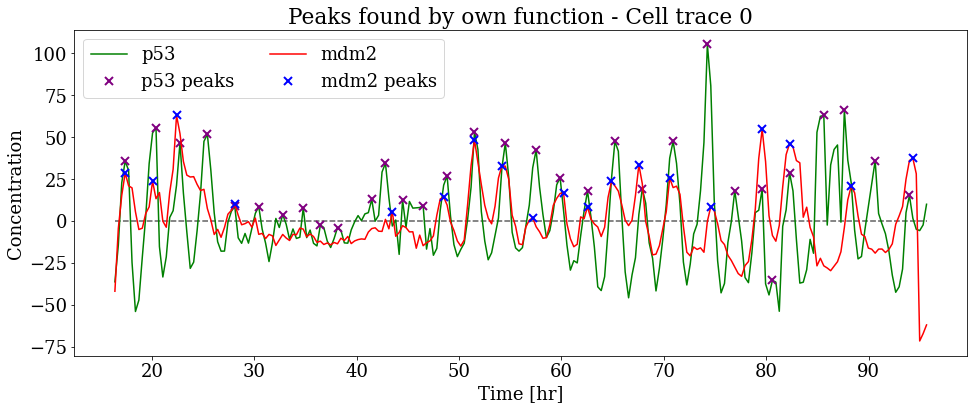

In [12]:
# Example of plots found by own function: 

fig, ax = plt.subplots(figsize=(16,6))

peak_plotter(t, resi_p0, own_peaks_p0, ax, 'p53')
peak_plotter(t, roll_resi_m0, own_peaks_m0, ax, 'mdm2')


ax.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='Peaks found by own function - Cell trace 0')
ax.legend(ncol=2)

if save_plots: 
    fig.savefig(r'Graphs/AllPeaksOwn.png');

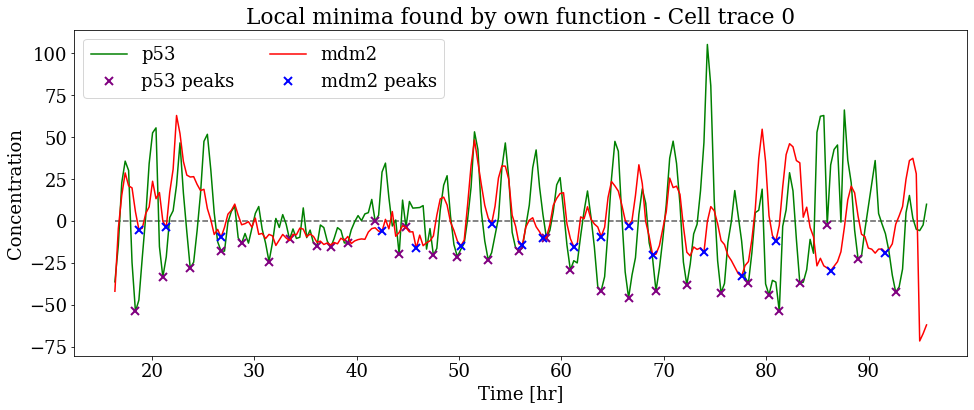

In [13]:
# Local minima found by own function: 

fig, ax = plt.subplots(figsize=(16,6))

peak_plotter(t, resi_p0, local_min_idx_p0, ax, 'p53')
peak_plotter(t, roll_resi_m0, local_min_idx_m0, ax, 'mdm2')


ax.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='Local minima found by own function - Cell trace 0')
ax.legend(ncol=2)

if save_plots: 
    fig.savefig(r'Graphs/AllMinimaOwn.png');

In [14]:
# Finding the unmatched peaks for all cells: 

all_peaks_p = [] 
all_peaks_m = [] 

all_local_min_p = []
all_local_min_m = []

mdm2_slips = [] 
mdm2_slips_min = [] 

for i in range(len(resi_p)): 
    
    peaks_p, min_p = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_m)
    peaks_m, min_m = peak_finder(roll_resi_m[i], N_peaks='low', threshold=avefluct_m)
    
    all_peaks_p.append(peaks_p)
    all_peaks_m.append(peaks_m)
    
    all_local_min_p.append(min_p)
    all_local_min_m.append(min_m)
    
    slips, slips_min = compare_peaks(peaks_p, peaks_m, min_p)[1:]
    mdm2_slips.append(slips)
    mdm2_slips_min.append(slips_min)

In [37]:
# Counting the number of p53 peaks: 

count_p_peaks = 0 

for i in all_peaks_p: 
    count_p_peaks += len(i)
    
    
print(f'Total number of p53 peaks detected: {count_p_peaks}')

Total number of p53 peaks detected: 12097


In [110]:
# Counting the number of skips found initially: 

count_slips = 0 

for i in mdm2_slips: 
    count_slips += len(i)
    
print(f'Number of skips found initially: {count_slips}')
print(f'Percentage of p53 peaks, where skips happens: {count_slips/count_p_peaks * 100:2.1f}%')

Number of skips found initially: 2993
Percentage of p53 peaks, where skips happens: 24.7%


In [16]:
# Checking if there is slips in all of the traces: 
# And if there is a trace with no slip, I will delete it: 

trace_no_skip_p = []
trace_no_skip_m = []

for i in range(0, 401):
    if len(mdm2_slips[i]) == 0:
        print(f"There is no skips in the {i}'th trace ")
        trace_no_skip_p.append(resi_p[i])
        trace_no_skip_m.append(resi_m[i])
        resi_p.pop(i)
        resi_m.pop(i)
        roll_resi_m.pop(i)
        all_peaks_p.pop(i)
        all_peaks_m.pop(i)
        all_local_min_p.pop(i)
        all_local_min_m.pop(i)
        mdm2_slips.pop(i)
        mdm2_slips_min.pop(i)

There is no skips in the 130'th trace 


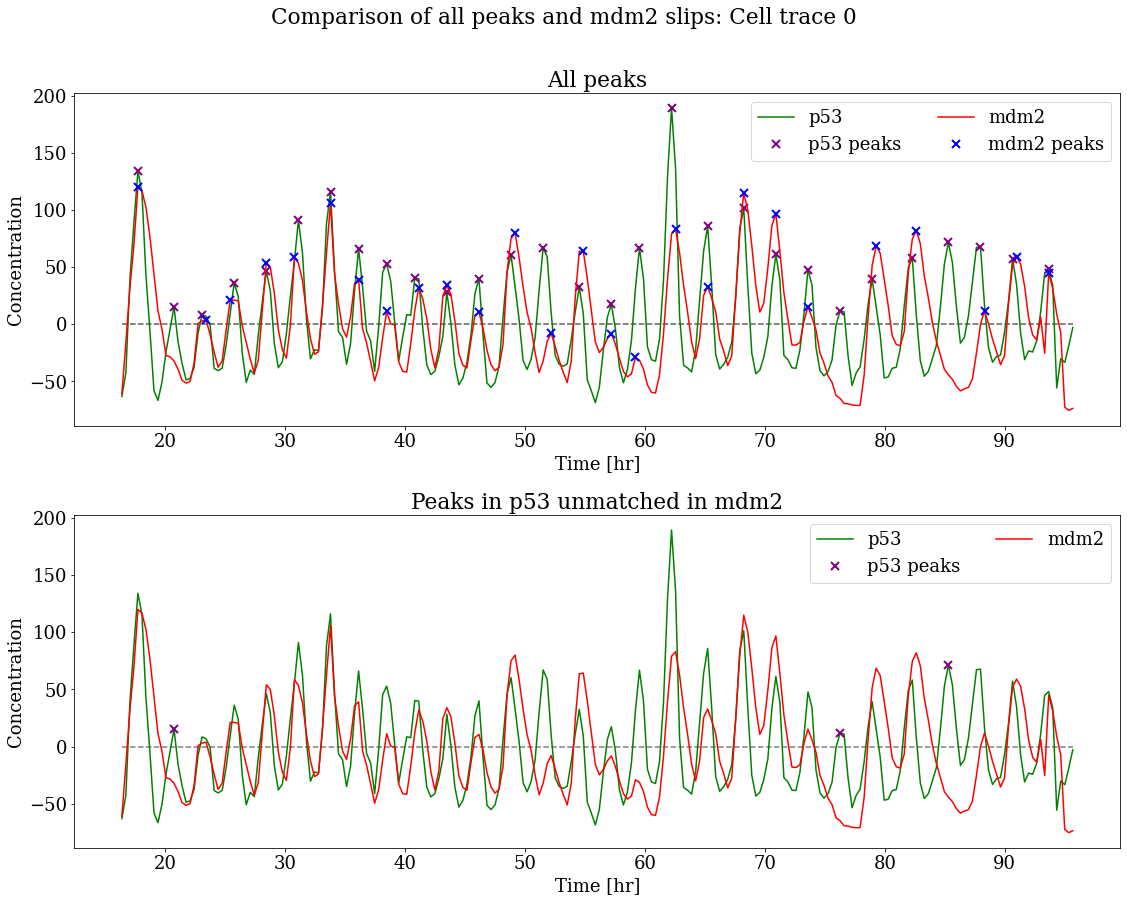

In [19]:
# Plotting peaks and slips: 

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
        
fig.suptitle(f'Comparison of all peaks and mdm2 slips: Cell trace 0', y=1.05)

peak_plotter(t, resi_p[286], all_peaks_p[286], ax1, 'p53')
peak_plotter(t, np.array(roll_resi_m)[286], all_peaks_m[286], ax1, 'mdm2')


ax1.set(xlabel='Time [hr]', 
        ylabel='Concentration', 
        title='All peaks')
ax1.legend(ncol=2)
        
        
peak_plotter(t, resi_p[286], mdm2_slips[286], ax2, 'p53')
ax2.plot(t, roll_resi_m[286], color='red', label='mdm2')


ax2.set(xlabel='Time [hr]', 
        ylabel='Concentration', 
        title='Peaks in p53 unmatched in mdm2')
ax2.legend(ncol=2)
        
fig.tight_layout() 

In [20]:
# Comparing distributions of all amplitudes of p53 and mdm2: 
# Taking all the possible peaks using N_peaks='high' for both p53 and mdm2

all_amplitudes_p = []
all_amplitudes_m = []

for i in range(len(resi_p)):
    peaks_p, local_min_p = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_m)
    peaks_m, local_min_m = peak_finder(resi_m[i], N_peaks='high', threshold=avefluct_m)
    
    all_amplitudes_p.extend(amplitudes(resi_p[i], peaks_p, local_min_p))
    all_amplitudes_m.extend(amplitudes(resi_m[i], peaks_m, local_min_m))

In [21]:
# Fitting the distribution of amplitudes with a gamma-function: 

def gamma_pdf(x, a, loc, scale) :
    """Gamma function"""
    return stats.gamma.pdf(x, a, loc, scale)


Nbins = 100 
xmin_p, xmax_p = np.min(all_amplitudes_p), np.max(all_amplitudes_p) 
xmin_m, xmax_m = np.min(all_amplitudes_m), np.max(all_amplitudes_m)

binwidth_p = (xmax_p - xmin_p) / (Nbins*2) 
binwidth_m = (xmax_m - xmin_m) / Nbins 


def norm_gamma_p(x, N, a, loc, scale):                       
    return N * binwidth_p * gamma_pdf(x, a, loc, scale)


def norm_gamma_m(x, N, a, loc, scale):                       
    return N * binwidth_m * gamma_pdf(x, a, loc, scale)

x_p, y_p, sy_p = zerobin_hist(all_amplitudes_p, Nbins*2, xmin_p, xmax_p, ax)
x_m, y_m, sy_m = zerobin_hist(all_amplitudes_m, Nbins, xmin_m, xmax_m, ax)

minuit_p = chi2_test(all_amplitudes_p, Nbins*2, xmin_p, xmax_p, norm_gamma_p, len(all_amplitudes_p), 90, 10, 1) 
minuit_m = chi2_test(all_amplitudes_m, Nbins, xmin_m, xmax_m, norm_gamma_m, len(all_amplitudes_m), 10, 20, 5) 

# Get the values from the fit: 
print('Fit values for p53:')
chi2_value_p, Ndof_p, p_value_p = get_chi2_values(minuit_p, Nbins*2)

print('\nFit values for mdm2:')

chi2_value_m, Ndof_m, p_value_m = get_chi2_values(minuit_m, Nbins)

Fit values for p53:
Fit value: N = 12164.21280 +/- 109.03131
Fit value: a = 15.89041 +/- 0.76345
Fit value: loc = -105.05170 +/- 4.28002
Fit value: scale = 11.66482 +/- 0.30143
Chi2 value: 256.5   Ndof = 196    Prob(Chi2,Ndof) = 0.002

Fit values for mdm2:
Fit value: N = 14830.20456 +/- 1453.68409
Fit value: a = 2.23532 +/- 0.40659
Fit value: loc = -31.34109 +/- 11.70975
Fit value: scale = 26.45922 +/- 1.80435
Chi2 value: 84.5   Ndof = 96    Prob(Chi2,Ndof) = 0.792


The p53 amplitudes are generally higher than those of mdm2


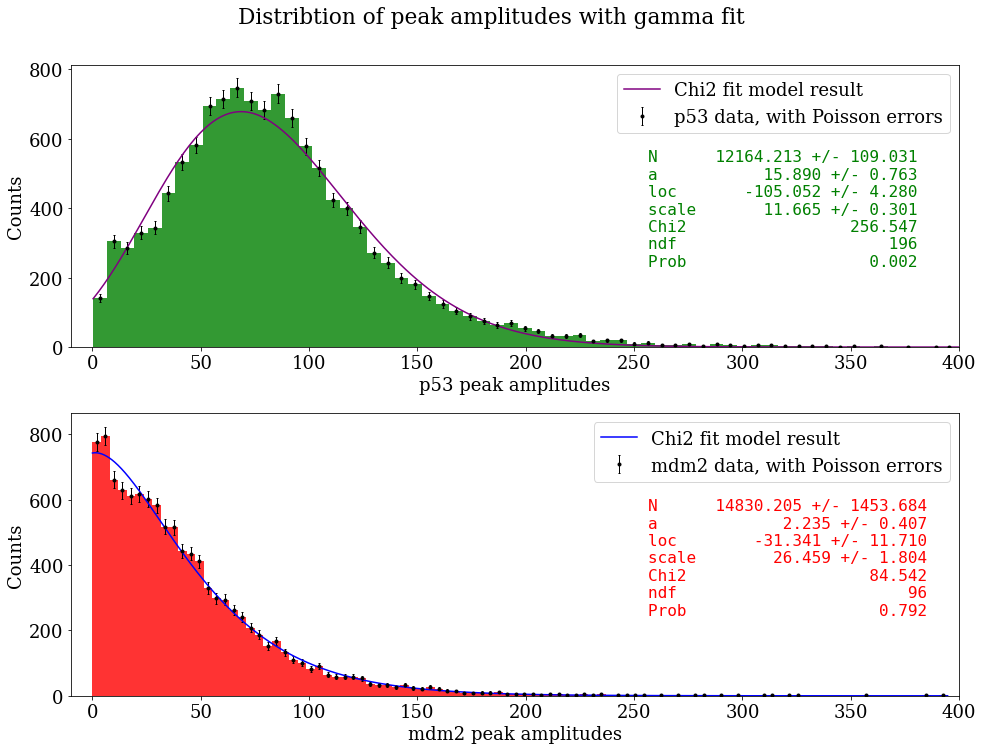

In [22]:
# Plot the data + fit for visualisation: 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))  # figsize is in inches
fig.suptitle('Distribtion of peak amplitudes with gamma fit', y=1.05)

ax1.hist(all_amplitudes_p, Nbins*2, range=(xmin_p, xmax_p), color='green', alpha=0.8)
ax1.errorbar(x_p, y_p, yerr=sy_p, label='p53 data, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax1.set(xlabel = "p53 peak amplitudes",
       ylabel = "Counts",
       xlim = (-10, 400))

xaxis_p = np.linspace(xmin_p, xmax_p, 1000)
ax1.plot(xaxis_p, norm_gamma_p(xaxis_p, *minuit_p.values[:]), 
         linestyle='-', color='purple', label='Chi2 fit model result') 

# Adding fit results to plot:
d_p = {'N':   [minuit_p.values['N'], minuit_p.errors['N']],
     'a':       [minuit_p.values['a'], minuit_p.errors['a']],
     'loc':       [minuit_p.values['loc'], minuit_p.errors['loc']],
     'scale':       [minuit_p.values['scale'], minuit_p.errors['scale']],
     'Chi2':     chi2_value_p,
     'ndf':      Ndof_p,
     'Prob':     p_value_p,
    }

text_p = nice_string_output(d_p, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.7, text_p, ax1, fontsize=16, color='green')
ax1.legend(loc='upper right')

ax2.hist(all_amplitudes_m, Nbins, range=(xmin_m, xmax_m), color='red', alpha=0.8)
ax2.errorbar(x_m, y_m, yerr=sy_m, label='mdm2 data, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax2.set(xlabel = "mdm2 peak amplitudes",
       ylabel = "Counts",
       xlim = (-10, 400))

xaxis_m = np.linspace(xmin_m, xmax_m, 1000)
ax2.plot(xaxis_m, norm_gamma_m(xaxis_m, *minuit_m.values[:]), 
         linestyle='-', color='b', label='Chi2 fit model result') 

# Adding fit results to plot:
d_m = {'N':   [minuit_m.values['N'], minuit_m.errors['N']],
     'a':       [minuit_m.values['a'], minuit_m.errors['a']],
     'loc':       [minuit_m.values['loc'], minuit_m.errors['loc']],
     'scale':       [minuit_m.values['scale'], minuit_m.errors['scale']],
     'Chi2':     chi2_value_m,
     'ndf':      Ndof_m,
     'Prob':     p_value_m,
    }

text_m = nice_string_output(d_m, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.7, text_m, ax2, fontsize=16, color='red')
ax2.legend(loc='upper right')
fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/AllAmplitudesFit.png');
    
print('The p53 amplitudes are generally higher than those of mdm2')

In [23]:
# Function to analyse slips: 

def analyze_slips(data_p, data_m, local_min_p, slips): 
    '''Function to analyse area around a mdm2 slip. 
       Returns the p53 amplitude, '''
    
    if len(slips) == 0: 
        return 0 

        
    local_min_p_idx = get_min_idx(data_p, local_min_p)
    
    skip_times = [] 
    skip_areas_p = [] 
    skip_areas_m = []
    
    for i in slips: 
        idx = np.searchsorted(local_min_p_idx, i)
        
        if idx == 0: 
            skip_times.append(t[:local_min_p_idx[0]:])
            skip_areas_p.append(data_p[:local_min_p_idx[0]:])
            skip_areas_m.append(data_m[:local_min_p_idx[0]:])
        
        elif idx >= len(local_min_p_idx): 
            skip_times.append(t[local_min_p_idx[-1]:])
            skip_areas_p.append(data_p[local_min_p_idx[-1]:])
            skip_areas_m.append(data_m[local_min_p_idx[-1]:])
            
        else: 
            mask = np.arange(local_min_p_idx[idx-1], local_min_p_idx[idx], 1)
            skip_times.append(t[mask])
            skip_areas_p.append(data_p[mask])
            skip_areas_m.append(data_m[mask])
  
        
    std = [np.std(i, ddof=1) for i in skip_areas_m]
    
    level_difference = [abs(data_p[i] - data_m[i]) for i in slips] # Maybe this should be calculated differently
    
    local_max_idx = [np.argmax(i) for i in skip_areas_m]  # Don't think it makes sense to calculate this 
    
    max_diff = [(np.max(i) - np.min(i)) for i in skip_areas_m]

    
    return skip_times, skip_areas_p, skip_areas_m, std, level_difference, local_max_idx, max_diff

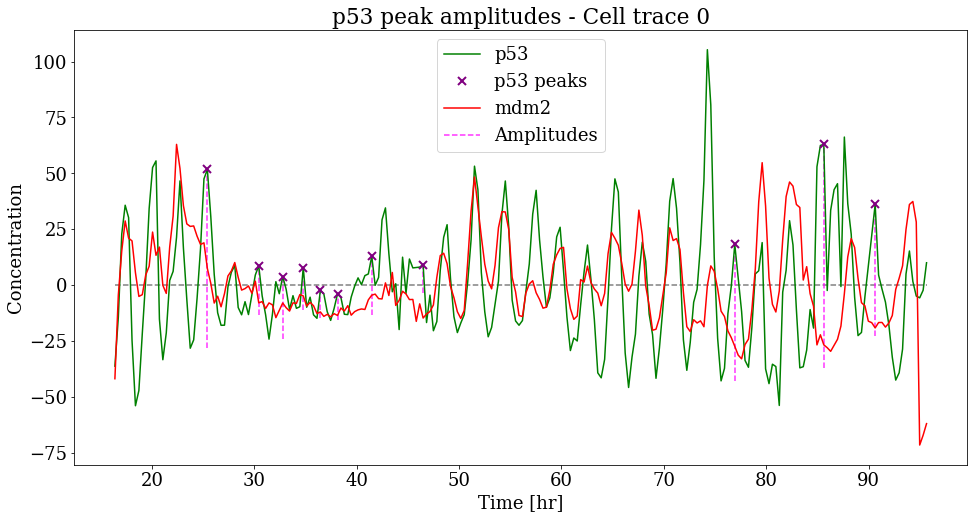

In [24]:
# Plotting the amplitudes for p53 at slips: 

fig, ax = plt.subplots(figsize=(16,8))

amp_plotter(t, resi_p[0], mdm2_slips[0], mdm2_slips_min[0], name='p53', ax=ax)
ax.plot(t, roll_resi_m[0], color='red', label='mdm2')

ax.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='p53 peak amplitudes - Cell trace 0')

ax.legend();

In [26]:
# Calculations for the slips: 

amp_slips_p = []         # p53 amplitudes at mdm2 slips
all_skip_times = [] 
all_skip_areas_p = []          # All areas around the slips 
all_skip_areas_m = []
level_difference = []    # The level difference at each slip 

for i in range(len(resi_p)):
    
    if len(mdm2_slips[i]) == 0: 
        continue 
        
    else: 
        amp_slips_p.extend(amplitudes(resi_p[i], mdm2_slips[i], mdm2_slips_min[i]))
        analysis = analyze_slips(resi_p[i], np.array(roll_resi_m)[i], all_local_min_p[i], mdm2_slips[i])
        all_skip_times.append(analysis[0])
        all_skip_areas_p.append(analysis[1])
        all_skip_areas_m.append(analysis[2])                   
        level_difference.extend(analysis[4])

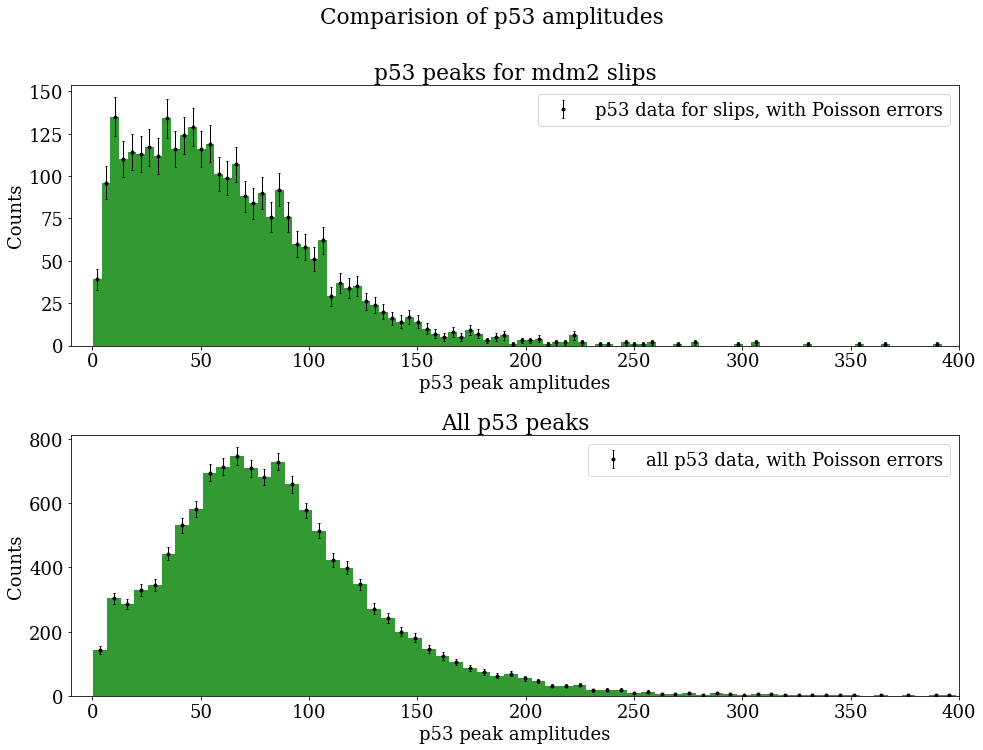

In [27]:
x_p1, y_p1, sy_p1 = zerobin_hist(amp_slips_p, Nbins, xmin_p, 400, ax)  # Histogram for all p53 amplitudes at slips

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))  

fig.suptitle('Comparision of p53 amplitudes', y=1.05)

ax1.hist(amp_slips_p, Nbins, range=(xmin_p, 400), color='green', alpha=0.8)
ax1.errorbar(x_p1, y_p1, yerr=sy_p1, label='p53 data for slips, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax1.set(xlabel = "p53 peak amplitudes",
       ylabel = "Counts",
       xlim = (-10, 400),
       title = 'p53 peaks for mdm2 slips')

ax1.legend()


ax2.hist(all_amplitudes_p, Nbins*2, range=(xmin_p, xmax_p), color='green', alpha=0.8)
ax2.errorbar(x_p, y_p, yerr=sy_p, label='all p53 data, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax2.set(xlabel = "p53 peak amplitudes",
       ylabel = "Counts",
       xlim = (-10, 400), 
       title = 'All p53 peaks')

ax2.legend()

fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/p53amp_slips.png');

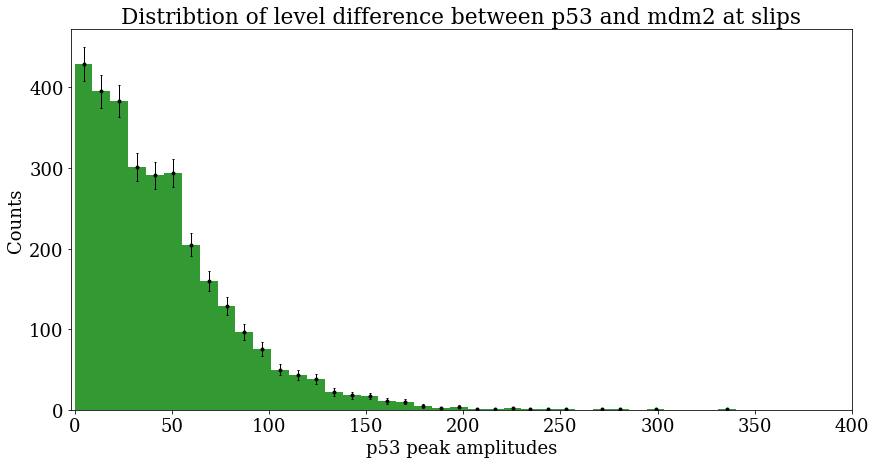

In [28]:
# Histogram for level difference at slips: 

x_p2, y_p2, sy_p2 = zerobin_hist(level_difference, Nbins, 0, np.max(level_difference), ax)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))  # figsize is in inches

ax.hist(level_difference, Nbins, range=(0, np.max(level_difference)), color='green', alpha=0.8)
ax.errorbar(x_p2, y_p2, yerr=sy_p2, label='p53 data, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax.set(xlabel = "p53 peak amplitudes",
       ylabel = "Counts",
       xlim = (-2, 400),
       title = 'Distribtion of level difference between p53 and mdm2 at slips')

if save_plots: 
    fig.savefig(r'Graphs/leveldiff_slips.png');

In [29]:
# Using the peak finder to check for mdm2 peaks in the area: 

peaks_in_slips = []  # List with peaks of mdm2 in slip areas 
local_mdm2_min = [] 

for i in all_skip_areas_m:
    
    in_slips = [] 
    min_in_slips = []
    
    for j in range(len(i)): 
        small_peak = peak_finder(i[j], 'high', avefluct_m)[0]   # Checking for peaks
        
        if len(small_peak) == 0:           # If the function doesn't find a peak None will be appended
            in_slips.append(None)
            min_in_slips.append(None)
            
        elif len(small_peak) > 1:          # If more than one peak is found in the slip area, we will choose the biggest 
            biggest_peak = np.where(np.max(i[j][small_peak]) == i[j])[0][0]
            in_slips.append(biggest_peak)
            min_in_slips.append(np.min(i[j][:biggest_peak]))
            
        else: 
            in_slips.append(small_peak[0])    # If a peak is found, the index will be appended
            min_in_slips.append(np.min(i[j][:small_peak[0]])) # Taking the minimum before 
            
    
    peaks_in_slips.append(in_slips)
    local_mdm2_min.append(min_in_slips)

In [32]:
count_peaks_in_slips = 0 

for i in peaks_in_slips:
    count = 0 
    for j in range(len(i)): 
        if i[j] != None: 
            count +=1
    count_peaks_in_slips += count

count_peaks_in_slips

print(f'Skips found by comparing arrays of peaks: {count_slips}')
print(f'Mdm2 peaks found i possible skip areas: {count_peaks_in_slips}')
print(f'Number of possible skips: {count_slips-count_peaks_in_slips}')

Skips found by comparing arrays of peaks: 2993
Mdm2 peaks found i possible skip areas: 1152
Number of possible skips: 1841


In [33]:
# Finding the amplitudes of the peaks: 

amp_mdm2_slips = []

for i in range(len(all_skip_areas_m)): 
    for j in range(len(all_skip_areas_m[i])):
        if peaks_in_slips[i][j] != None:     
            amp_mdm2_slips.extend(amplitudes(all_skip_areas_m[i][j], peaks_in_slips[i][j], local_mdm2_min[i][j]))

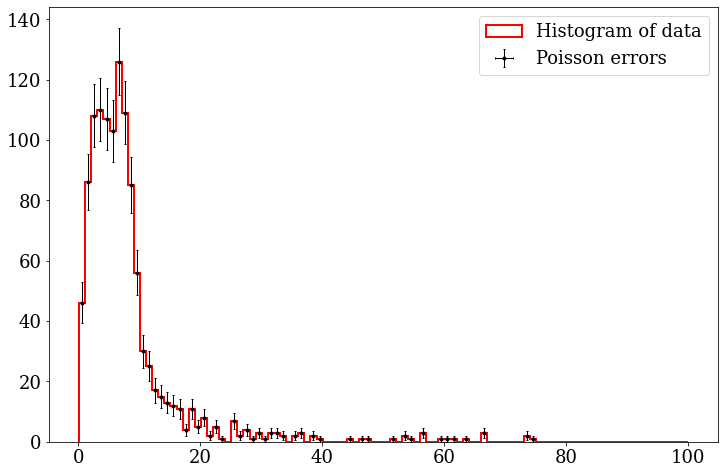

In [40]:
fig, ax = plt.subplots(figsize=(12,8))

zerobin_hist(amp_mdm2_slips, 100, min(amp_mdm2_slips), 100, ax);

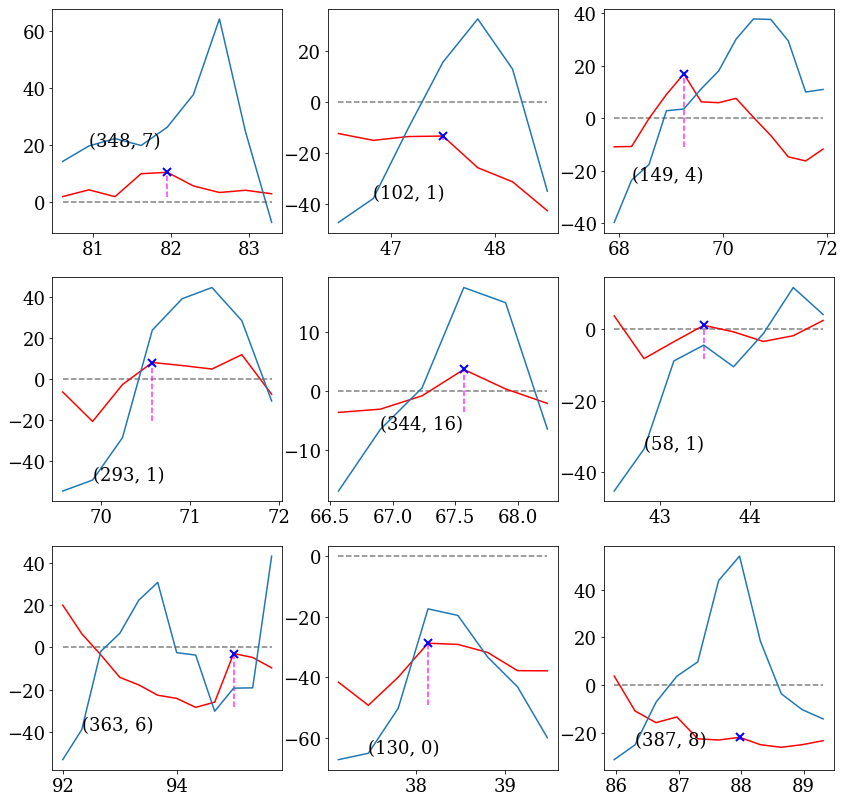

In [41]:
r = np.random    # Random generator
r.seed(42)       # Set a random seed (but a fixed one)

slip_time = np.linspace(0, 12, 12)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,14))

j = 0 
for i in range(3): 
    for j in range(3):
        idx_i = r.randint(0, len(all_skip_areas_m)+1, size=1)[0]
        idx_j = r.randint(0, len(all_skip_areas_m[idx_i]), size=1)[0]
        
        while peaks_in_slips[idx_i][idx_j] == None:
            idx_i = r.randint(0, len(all_skip_areas_m)+1, size=1)[0]
            idx_j = r.randint(0, len(all_skip_areas_m[idx_i]), size=1)[0]
            
        else:
            amp_plotter(all_skip_times[idx_i][idx_j], all_skip_areas_m[idx_i][idx_j], 
                        peaks_in_slips[idx_i][idx_j], local_mdm2_min[idx_i][idx_j], 'mdm2', ax[i,j])
            ax[i,j].plot(all_skip_times[idx_i][idx_j], all_skip_areas_p[idx_i][idx_j])
            ax[i,j].text(all_skip_times[idx_i][idx_j][1], all_skip_areas_p[idx_i][idx_j][1], f'{idx_i, idx_j}')
            